In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

In [2]:
print(os.listdir("data/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
app_train_df = pd.read_csv("data/application_train.csv")
app_test_df = pd.read_csv("data/application_test.csv")
column_description_df = pd.read_csv("data/HomeCredit_columns_description.csv", encoding='ISO-8859-1')
train_labels = app_train_df.iloc[:,:2]
test_id = app_test_df.iloc[:,0]

def column_description_lookup(column):
    print(column_description_df[column_description_df['Row']==column].Description.values[0])

In [4]:
app_train_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.000,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.000,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.000,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.000,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
app_train_missing_df = pd.DataFrame(app_train_df.isna().sum(axis=0).sort_values(ascending=False)).rename(columns={0:"Total"})
app_train_missing_df['%'] = np.round(app_train_missing_df.Total/len(app_train_df)*100, 2)
app_train_missing_df

,Total,%
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MEDI,210199,68.35
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35


In [6]:
app_test_missing_df = pd.DataFrame(app_test_df.isna().sum(axis=0).sort_values(ascending=False)).rename(columns={0:"Total"})
app_test_missing_df['%'] = np.round(app_test_missing_df.Total/len(app_test_df)*100, 2)
app_test_missing_df

,Total,%
COMMONAREA_MEDI,33495,68.72
COMMONAREA_AVG,33495,68.72
COMMONAREA_MODE,33495,68.72
NONLIVINGAPARTMENTS_MODE,33347,68.41
NONLIVINGAPARTMENTS_MEDI,33347,68.41
NONLIVINGAPARTMENTS_AVG,33347,68.41
FONDKAPREMONT_MODE,32797,67.28
LIVINGAPARTMENTS_AVG,32780,67.25
LIVINGAPARTMENTS_MEDI,32780,67.25
LIVINGAPARTMENTS_MODE,32780,67.25


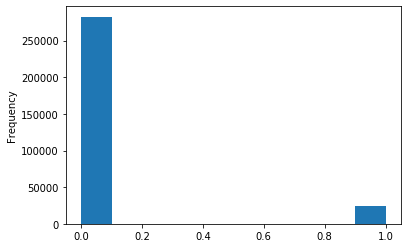

In [7]:
app_train_df.TARGET.plot.hist()

In [8]:
app_train_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Missing data in categorial features

In [9]:
feat_names = list(app_test_df.columns)
app_total_df = pd.concat([app_train_df[feat_names], app_test_df])

app_total_missing_df = pd.DataFrame(app_total_df.isna().sum(axis=0).sort_values(ascending=False)).rename(columns={0:"Total"})
app_total_missing_df['%'] = np.round(app_total_missing_df.Total/len(app_total_df)*100, 2)

In [10]:
app_total_missing_df.loc[app_total_df.select_dtypes('object').columns,:].sort_values(by='Total',ascending=False)

,Total,%
FONDKAPREMONT_MODE,243092,68.24
WALLSMATERIAL_MODE,180234,50.59
HOUSETYPE_MODE,177916,49.94
EMERGENCYSTATE_MODE,167964,47.15
OCCUPATION_TYPE,111996,31.44
NAME_TYPE_SUITE,2203,0.62
NAME_CONTRACT_TYPE,0,0.00
CODE_GENDER,0,0.00
FLAG_OWN_CAR,0,0.00
FLAG_OWN_REALTY,0,0.00


In [11]:
binary_cat_feats = app_train_df.select_dtypes('object').nunique()[app_train_df.select_dtypes('object').nunique()==2].index
cat_feats=app_train_df.select_dtypes('object').nunique()[app_train_df.select_dtypes('object').nunique()>2].index
total_cat_feats = list(binary_cat_feats) + list(cat_feats)
#non_missing_cat_feats = app_total_missing_df.loc[app_total_df.select_dtypes('object').columns,:][app_total_missing_df.loc[app_total_df.select_dtypes('object').columns,:]['Total']==0].index

**Handle categorical variables**

- Impute `EMERGENCYSTATE_MODE` with the majority class.
- Label encode the binary features
    - Store classes in `binary_feat_le_map`
- Get dummies for the rest of the categorical variables
    - Store dropped levels in `dropped_cat_feats`

In [12]:
app_train_df['EMERGENCYSTATE_MODE'] = app_train_df['EMERGENCYSTATE_MODE'].fillna('No')
app_test_df['EMERGENCYSTATE_MODE'] = app_test_df['EMERGENCYSTATE_MODE'].fillna('No')

binary_feat_le_map = {}
dropped_cat_feats = {}
# Encode missing data
for cat_feat in total_cat_feats:
    if app_train_df[cat_feat].nunique()==2:
        le = LabelEncoder()
        app_train_df[cat_feat] = le.fit_transform(app_train_df[cat_feat])
        app_test_df[cat_feat] = le.transform(app_test_df[cat_feat])
        binary_feat_le_map[cat_feat] = le.classes_
    else:
        most_freq_name = app_train_df[cat_feat].value_counts().sort_values(ascending=False).index[0]
        app_train_df = pd.get_dummies(app_train_df, columns=[cat_feat])
        app_train_df.drop(columns=cat_feat+'_'+most_freq_name, inplace=True)
        app_test_df = pd.get_dummies(app_test_df, columns=[cat_feat])
        app_test_df.drop(columns=cat_feat+'_'+most_freq_name, inplace=True)
        dropped_cat_feats[cat_feat] = most_freq_name

Drop OHE feats that are in training set but not in test set

In [13]:
for col in (set(app_train_df.columns) - set(app_test_df.columns)):
    app_train_df.drop(columns=col, inplace=True)

In [14]:
print(app_train_df.shape)
print(app_test_df.shape)

(307511, 226)
(48744, 226)


<br>
<br>

# Anomalies

In [15]:
column_description_lookup('DAYS_EMPLOYED')

How many days before the application the person started current employment


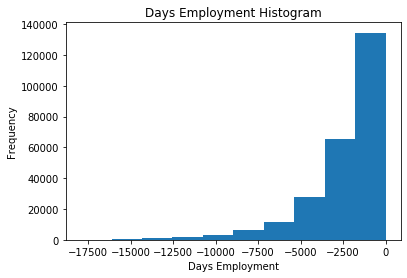

In [16]:
# Create an anomalous flag column
app_train_df['DAYS_EMPLOYED_ANOM'] = app_train_df["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train_df['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [17]:
app_test_df['DAYS_EMPLOYED_ANOM'] = app_test_df["DAYS_EMPLOYED"] == 365243
app_test_df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test_df["DAYS_EMPLOYED_ANOM"].sum(), len(app_test_df)))

There are 9274 anomalies in the test data out of 48744 entries


<br>
<br>

# Feature Engineering

In [18]:
# Make a new dataframe for polynomial features
poly_features = app_train_df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].copy()
poly_features['TARGET'] = train_labels['TARGET'].copy()
poly_features_test = app_test_df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].copy()

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [19]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [20]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


We will add these features to a copy of the training and testing data and then evaluate models with and without the features.

In [21]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train_df['SK_ID_CURR']
app_train_poly = app_train_df.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test_df['SK_ID_CURR']
app_test_poly = app_test_df.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 262)
Testing data with polynomial features shape:   (48744, 262)


**Domain Knowledge Features**

- **CREDIT_INCOME_PERCENT**: the percentage of the credit amount relative to a client's income
- **ANNUITY_INCOME_PERCENT**: the percentage of the loan annuity relative to a client's income
- **CREDIT_TERM**: the length of the payment in months (since the annuity is the monthly amount due
- **DAYS_EMPLOYED_PERCENT**: the percentage of the days employed relative to the client's age

In [22]:
app_train_domain = app_train_df.copy()
app_test_domain = app_test_df.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

<br>
<br>

Combine poly and domain features

In [23]:
for col in set(app_train_domain.columns) - set(app_train_poly.columns):
    app_train_poly[col] = app_train_domain[col]
    app_test_poly[col] = app_test_domain[col]
print(app_train_poly.shape)

(307511, 270)


<br>
<br>

**Get train data**

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in app_train_df:
    #train = app_train_df.drop(columns = ['TARGET'])
    #train = app_train_domain.drop(columns=['TARGET'])
    train = app_train_poly.drop(columns=['TARGET'])
else:
    #train = app_train_df.copy()
    #train = app_train_domain.copy()
    train = app_train_poly.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
#test = app_test_df.copy()
#test = app_test_domain.copy()
test = app_test_poly.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = StandardScaler()

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
#scaler.fit(train)
#train = scaler.transform(train)
#test = scaler.transform(test)

label = train_labels['TARGET'].values

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 270)
Testing data shape:  (48744, 270)


In [25]:
train_df = pd.DataFrame(train, columns=features)
test_df = pd.DataFrame(test, columns=features)

In [26]:
train_df.to_csv("app_train_poly.csv", index=False)
test_df.to_csv("app_test_poly.csv", index=False)

<br>
<br>

# Logistic Regression Baseline

**Gridsearch**

In [ ]:
log_regr = LogisticRegression(penalty='l1',
                              solver='linear',
                              max_iter=1000,
                              n_jobs=1
                             )

log_regr_gs = GridSearchCV(log_regr, 
                           {'C':np.logspace(-4,-2,40)},
                           scoring='roc_auc',
                           n_jobs=4,
                           iid=False,
                           cv=5,
                           verbose=2
                          )
best_log_regr = log_regr_gs.fit(train, train_labels['TARGET'].values)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
cv_results = pd.DataFrame(best_log_regr.cv_results_)
import seaborn as sns
sns.lineplot(x='param_C', y='mean_test_score', data=cv_results)
plt.xscale('log')

In [ ]:
best_log_regr.best_params_

<br>
<br>

**Get submission**

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log_regr = LogisticRegression(penalty='l1',
                              solver='liblinear',
                              max_iter=1000,
                              n_jobs=1,
                              C = 0.04,
                              class_weight='balanced'
                             )
log_regr.fit(train, train_labels['TARGET'].values)

LogisticRegression(C=0.04, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=1, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
y_pred = log_regr.predict_proba(test)
submission_df = pd.DataFrame(test_id)
submission_df['TARGET'] = y_pred[:,1]

In [27]:
submission_df.to_csv("26082019_4.csv", index=False)

- **0.73331** - No FE
- **0.73452** - "domain" features
- **0.73602** - Poly features
- **0.73720** - Poly & "domain" features
- **0.73877** - Poly & "domain" features, `class_weight` = 'balanced

<br>
<br>

# LightGBM baseline

In [ ]:
train_df = pd.read_csv("app_train_poly.csv")
test_df = pd.read_csv("app_test_poly.csv")
train = train_df.iloc[:,1:].values
test = test_df.iloc[:,1:].values 
label = train_labels['TARGET'].values

In [5]:
cv_n_estimators = []
cv_scores = []

skf = StratifiedKFold(n_splits=5)

for train_index, val_index in skf.split(X=train, y=label):
    X_train, y_train = train[train_index], label[train_index]
    X_val, y_val = train[val_index], label[val_index]
    
    model = LGBMClassifier(n_estimators=10000, 
                           num_leaves=20,
                           objective = 'binary', 
                           class_weight = 'balanced', 
                           learning_rate = 0.05, 
                           #reg_alpha = 0.1, 
                           #reg_lambda = 0.1, 
                           subsample = 0.8, 
                           colsample_by_tree=0.25,
                           n_jobs = 4, 
                           random_state = 50)
    
    model.fit(X_train, 
              y_train, 
              eval_metric = 'auc',
              eval_set = [(X_val, y_val)],
              eval_names = ['valid'], 
              categorical_feature = 'auto',
              early_stopping_rounds = 50, 
              verbose = 200)
    
    cv_n_estimators.append(model.best_iteration_)
    cv_scores.append(model.best_score_['valid']['auc'])

Training until validation scores don't improve for 50 rounds.
[200]	valid's auc: 0.764854	valid's binary_logloss: 0.566332
[400]	valid's auc: 0.766409	valid's binary_logloss: 0.552086
Early stopping, best iteration is:
[401]	valid's auc: 0.766435	valid's binary_logloss: 0.551998
Training until validation scores don't improve for 50 rounds.
[200]	valid's auc: 0.76483	valid's binary_logloss: 0.570713
Early stopping, best iteration is:
[325]	valid's auc: 0.765504	valid's binary_logloss: 0.561651
Training until validation scores don't improve for 50 rounds.
[200]	valid's auc: 0.759198	valid's binary_logloss: 0.566892
[400]	valid's auc: 0.760007	valid's binary_logloss: 0.553415
Early stopping, best iteration is:
[409]	valid's auc: 0.760076	valid's binary_logloss: 0.552819
Training until validation scores don't improve for 50 rounds.
[200]	valid's auc: 0.765986	valid's binary_logloss: 0.565253
[400]	valid's auc: 0.767283	valid's binary_logloss: 0.551524
Early stopping, best iteration is:
[38

In [6]:
print(cv_n_estimators)

[401, 325, 409, 380, 453]


In [7]:
print(cv_scores)

[0.7664347592580658, 0.7655041148805385, 0.7600760731313367, 0.7673240639621771, 0.7686647646424488]


<br>
<br>

**Get submission**

In [13]:
model = LGBMClassifier(n_estimators=600, 
                           num_leaves=20,
                           objective = 'binary', 
                           class_weight = 'balanced', 
                           learning_rate = 0.05, 
                           subsample = 0.8, 
                           colsample_by_tree=0.25,
                           n_jobs = 4, 
                           random_state = 50)

model.fit(train, 
          label, 
          eval_metric = 'auc',
          categorical_feature = 'auto',
         )

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_by_tree=0.25, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=600, n_jobs=4, num_leaves=20, objective='binary',
               random_state=50, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [14]:
y_pred = model.predict_proba(test)[:,1]
submission_df = pd.DataFrame(test_id)
submission_df['TARGET'] = y_pred

In [15]:
submission_df.to_csv("26082019_8.csv", index=False)

- **0.76057** - "Domain" and poly features LightGBM
- **0.76002** - "Domain" and poly features LightGBM. No reg, n_estimators=400
- **0.76050** - "Domain" and poly features LightGBM. No reg, No ID feature, n_estimators=450
- **0.76110** - "Domain" and poly features LightGBM. No reg, No ID feature, n_estimators=600

In [23]:
feat_importance = {}
for idx, feat in enumerate(train_df.columns):
    feat_importance[feat] = model.feature_importances_[idx]
feat_importance = pd.Series(feat_importance)

<br>
<br>

# Other tables

**Aggregate Feature Engineering**

In [4]:
app_train_df = pd.read_csv("app_train_poly.csv")
app_test_df = pd.read_csv("app_test_poly.csv")
app_train_df['SK_ID_CURR'] = app_train_df['SK_ID_CURR'].values.astype(int)
app_test_df['SK_ID_CURR'] = app_test_df['SK_ID_CURR'].values.astype(int)
label = train_labels['TARGET'].values
bureau = pd.read_csv("data/bureau.csv")
bureau_balance = pd.read_csv("data/bureau_balance.csv")

In [5]:
print(os.listdir("data/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


<br>
<br>

**Aggregating Numeric Columns**

In [6]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            The feature to group on
        df_name (string): 
            prefix added to each feature indicating which df the feature came from
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg_stats = ['count', 'mean', 'max', 'min', 'sum']
    agg = numeric_df.groupby(group_var).agg(agg_stats).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg_stats:
                # Make a new column name for the variable and stat
                columns.append('{}_{}_{}'.format(df_name, var, stat))

    agg.columns = columns
    return agg

<br>
<br>

**Aggregating categorical Columns**

In [7]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))
    
    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var].copy()

    # Drop low populated categorical variables
    categorical.drop(columns=list(categorical.sum(axis=0)[categorical.sum(axis=0)<5000].index), inplace=True)
    
    # Groupby the group var and calculate the sum and mean
    #categorical = categorical.groupby(group_var, as_index=False).sum()
    categorical = categorical.groupby(group_var).agg(['mean'])
    
    #column_names = [group_var]
    column_names = []
    
    # Iterate through the columns in level 0
    #for col in categorical.columns:
    #    if col != group_var:
    #        column_names.append("{}_{}_{}".format(df_name, col, "count"))
    # 
    #
    #categorical.columns = column_names
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        column_names.append('{}_{}_{}'.format(df_name, var, 'count_norm'))
    
    categorical.columns = column_names
    categorical.reset_index(level=0, inplace=True)
    
    return categorical

In [8]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg = pd.concat([bureau_agg, bureau_counts.drop(columns="SK_ID_CURR")], axis=1)
del(bureau_counts)

<br>
<br>

**Bureau balance**

Aggregate on each loan

In [9]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg = pd.concat([bureau_balance_agg,bureau_balance_counts.drop(columns="SK_ID_BUREAU")], axis=1)
bureau_balance_agg
del(bureau_balance_counts)

Aggregate on each applicant

In [10]:
bureau_balance_by_loan = bureau[['SK_ID_CURR', 'SK_ID_BUREAU']].merge(bureau_balance_agg, how='left', on='SK_ID_BUREAU')
bureau_balance_by_applicant = agg_numeric(bureau_balance_by_loan, group_var='SK_ID_CURR', df_name = 'client')
del(bureau_balance_by_loan)

Merge aggregated aggregated previous loan info into app_train_df

In [11]:
app_train_df = app_train_df.merge(bureau_agg, how='left', on='SK_ID_CURR')
app_train_df = app_train_df.merge(bureau_balance_by_applicant, how='left', on='SK_ID_CURR')

Test set

In [12]:
app_test_df = app_test_df.merge(bureau_agg, how='left', on='SK_ID_CURR')
app_test_df = app_test_df.merge(bureau_balance_by_applicant, how='left', on='SK_ID_CURR')

Align

In [13]:
app_train_df, app_test_df = app_train_df.align(app_test_df, join = 'inner', axis = 1)

<br>
<br>

# LightGBM baseline

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

train = app_train_df.iloc[:,1:].values
test = app_test_df.iloc[:,1:].values

# Feature names
features = list(app_train_df.columns)

#imputer = SimpleImputer(strategy='median')

#train = imputer.fit_transform(app_train_df.iloc[:,1:].values)
#test = imputer.transform(app_test_df.iloc[:,1:].values)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 403)
Testing data shape:  (48744, 403)


<br>
<br>

In [16]:
cv_n_estimators = []
cv_scores = []
fi = []

skf = StratifiedKFold(n_splits=5)

for train_index, val_index in skf.split(X=train, y=label):
    X_train, y_train = train[train_index], label[train_index]
    X_val, y_val = train[val_index], label[val_index]
    
    model = LGBMClassifier(n_estimators=10000, 
                           num_leaves=31,
                           objective = 'binary', 
                           class_weight = 'balanced', 
                           learning_rate = 0.05, 
                           #reg_alpha = 0.1, 
                           #reg_lambda = 0.1, 
                           subsample = 0.8, 
                           colsample_by_tree=0.25,
                           n_jobs = 4, 
                           random_state = 50)
    
    model.fit(X_train, 
              y_train, 
              eval_metric = 'auc',
              eval_set = [(X_val, y_val)],
              eval_names = ['valid'], 
              categorical_feature = 'auto',
              early_stopping_rounds = 100, 
              verbose = 200)
    
    cv_n_estimators.append(model.best_iteration_)
    cv_scores.append(model.best_score_['valid']['auc'])
    fi.append(model.feature_importances_)

Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.771113	valid's binary_logloss: 0.548595
[400]	valid's auc: 0.77257	valid's binary_logloss: 0.526118
Early stopping, best iteration is:
[379]	valid's auc: 0.772742	valid's binary_logloss: 0.528283
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.772587	valid's binary_logloss: 0.552684
Early stopping, best iteration is:
[283]	valid's auc: 0.77406	valid's binary_logloss: 0.542115
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.767246	valid's binary_logloss: 0.549817
Early stopping, best iteration is:
[230]	valid's auc: 0.767857	valid's binary_logloss: 0.545926
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.774026	valid's binary_logloss: 0.547437
Early stopping, best iteration is:
[230]	valid's auc: 0.77455	valid's binary_logloss: 0.54367
Training until validation scores don't improve for 100 rounds.


In [17]:
print(cv_n_estimators)

[379, 283, 230, 230, 258]


In [18]:
print(cv_scores)

[0.7727419824440901, 0.7740595189194339, 0.7678565887063309, 0.7745500709540781, 0.772525448805095]


<br>
<br>

In [15]:
model = LGBMClassifier(n_estimators=320, 
                           num_leaves=31,
                           objective = 'binary', 
                           class_weight = 'balanced', 
                           learning_rate = 0.05, 
                           #reg_alpha = 0.1, 
                           #reg_lambda = 0.1, 
                           subsample = 0.8, 
                           colsample_by_tree=0.25,
                           n_jobs = 4, 
                           random_state = 50)

model.fit(train, 
          label, 
          eval_metric = 'auc',
          categorical_feature = 'auto',
         )

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_by_tree=0.25, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=320, n_jobs=4, num_leaves=31, objective='binary',
               random_state=50, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [16]:
y_pred = model.predict_proba(test)[:,1]
submission_df = pd.DataFrame(test_id)
submission_df['TARGET'] = y_pred

In [17]:
submission_df.to_csv("27082019_6.csv", index=False)

- **0.76968** - "Domain", poly and bureau aggregated features. Missing values not imputed, n_estimators = optimal, num_leaves=31
- **0.76889** - "Domain", poly and bureau aggregated features. Missing values not imputed, n_estimators = 600
- **0.76965** - "Domain", poly and bureau aggregated features. Missing values not imputed, n_estimators=optimal, num_leaves=21, colsample_by_tree=0.2
- **0.76947** - "Domain", poly and bureau aggregated features. Missing values imputed, n_estimators=optimal, num_leaves=31, colsample_by_tree=0.25
- **0.76896** - "Domain", poly and bureau aggregated features. Missing values not imputed, n_estimators = optimal, colsample_by_tree = 0.5
- **0.76950** - "Domain", poly and bureau aggregated features. Missing values not imputed, n_estimators = optimal, num_leaves=31 **count_norms**

<br>
<br>

# To do

- ~~Example in the notebook does not drop first~~
- ~~Drop the most common column when using `pd.get_dummies`~~
- ~~Impute the majority class inside the binary cat feature that has missing values~~
- ~~Make predictions on Engineered features~~
- Subsample columns to perform GridSearch on C parameter for LogisticRegression
- ~~Add more FE (aggregate features)~~
- ~~Test LGBM for app+aggregate features with missing data **not** imputed~~
- ~~Test LGBM for app+aggregate features with missing data imputed~~
- Test LGBM for app+aggregate features with low importance features removed
- Figure out a good way to display the distributions of many features in a single plot